In [1]:
# Import packages
from tools.to_read import *
from tools.to_plot import *
from tools.to_do import *
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Set up
root='/home/jacoponudo/Documents/Size_effects/'
platform='gab'

# Read data
data = pd.read_parquet(root + 'DATA/' + platform + '/'+platform+'_raw_data.parquet', columns=columns_to_read[platform])
data.columns=standard_columns
data['timestamp'] = pd.to_datetime(data['timestamp'])

/home/jacoponudo/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


# Dinamiche collettive 

#### 1. Numero di utenti coinvolti in una conversazione

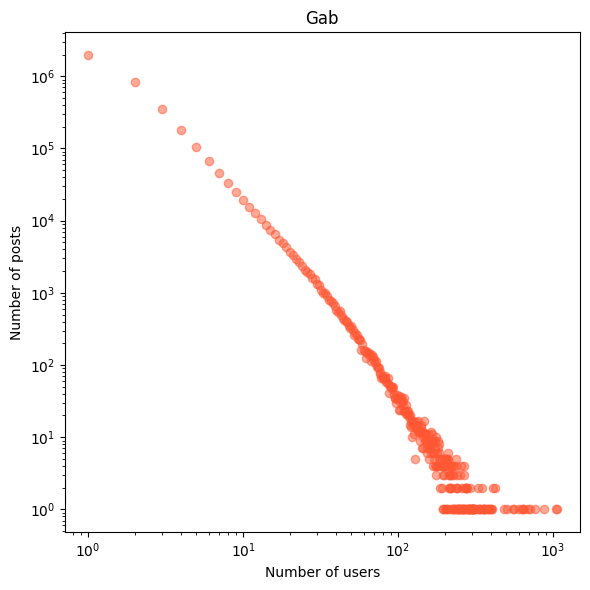

In [2]:
unique_users_per_post = data.groupby('post_id')['user_id'].nunique().reset_index()
unique_users_per_post.columns = ['post_id', 'unique_users_count']
unique_users_per_post.to_csv(root+'PAPER/output/1_section/1_users_in_thread_{}.csv'.format(platform))

distribution = unique_users_per_post['unique_users_count'].value_counts().sort_index()

plt.figure(figsize=(6, 6))
plt.scatter(distribution.index, distribution.values, color=palette[platform], alpha=0.5)  # Alpha added for transparency
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of users')
plt.ylabel('Number of posts')
plt.title(str(platform.capitalize()))
plt.grid(False)
plt.tight_layout()

plt.savefig(root+'PAPER/output/1_section/1_users_in_thread_{}.png'.format(platform))
plt.show()


#### 2. Durata della conversazione

In [3]:


# Esempio di utilizzo: calcolare il 95° percentile e salvare il file
output_path =root+'PAPER/output/1_section/2_lifetime_thread_{}.csv'.format(platform)
calculate_lifetime_percentile(data, 80, output_path)

df = pd.read_csv(output_path)

# Rimuovi i valori NA dalla colonna del lifetime
df_clean = df.dropna(subset=['duration_percentile'])

# Crea un plot della distribuzione
plt.figure(figsize=(6, 6))
sns.kdeplot(data=df_clean, x='duration_percentile', fill=True, common_norm=False,color=palette[platform])

# Imposta l'asse x in scala logaritmica
plt.xscale('log')

# Aggiungi titolo e etichette
plt.title(str(platform.capitalize()))
plt.xlabel('Lifetime (hours)')
plt.ylabel('Density')

plt.grid(False)

# Mostra il grafico
plt.savefig(root+'PAPER/output/1_section/2_lifetime_thread_{}.png'.format(platform))
plt.show()


Calcolando durata 80° percentile per ogni post:   1%|          | 30399/3764443 [00:11<24:13, 2569.26it/s]


KeyboardInterrupt: 

#### 3. Concentration of the conversation

/tmp/ipykernel_725362/3372283483.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data['hour'] = data['timestamp'].dt.floor('H')


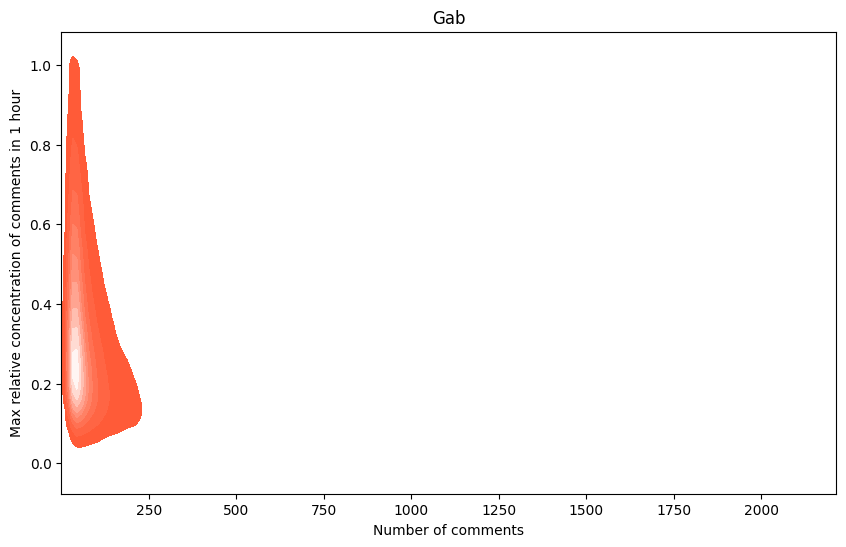

In [4]:



data['hour'] = data['timestamp'].dt.floor('H')
comments_per_hour = data.groupby(['post_id', 'hour']).size().reset_index(name='comment_count')
max_concentration = comments_per_hour.groupby('post_id')['comment_count'].max().reset_index(name='max_absolute_concentration')

total_comments = data.groupby('post_id').size().reset_index(name='total_comments')
results_df = pd.merge(max_concentration, total_comments, on='post_id')
results_df['relative_concentration'] = results_df['max_absolute_concentration'] / results_df['total_comments']

results_df.to_csv(root+'PAPER/output/1_section/3_concentration_of_comments_{}.csv'.format(platform))
filtered_results_df = results_df[results_df['total_comments'] > 30]

platform_color = palette[platform]  # Ad esempio, il colore arancione che volevi usare

# Definire una scala di colori che parte da 'platform_color' e termina con il bianco
cmap = LinearSegmentedColormap.from_list("platform_to_white", [platform_color, 'white'])

# Supponiamo che il tuo dataframe si chiami 'filtered_results_df'
plt.figure(figsize=(10, 6))
sns.kdeplot(x=filtered_results_df['total_comments'], y=filtered_results_df['relative_concentration'], cmap=cmap, fill=True)

plt.title(str(platform.capitalize()))
plt.ylabel('Max relative concentration of comments in 1 hour')
plt.xlabel('Number of comments')

plt.savefig(root+'PAPER/output/1_section/3_concentration_of_comments_{}.png'.format(platform))
plt.show()


#### 4. Level of dialogue

/tmp/ipykernel_725362/4255907686.py:50: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


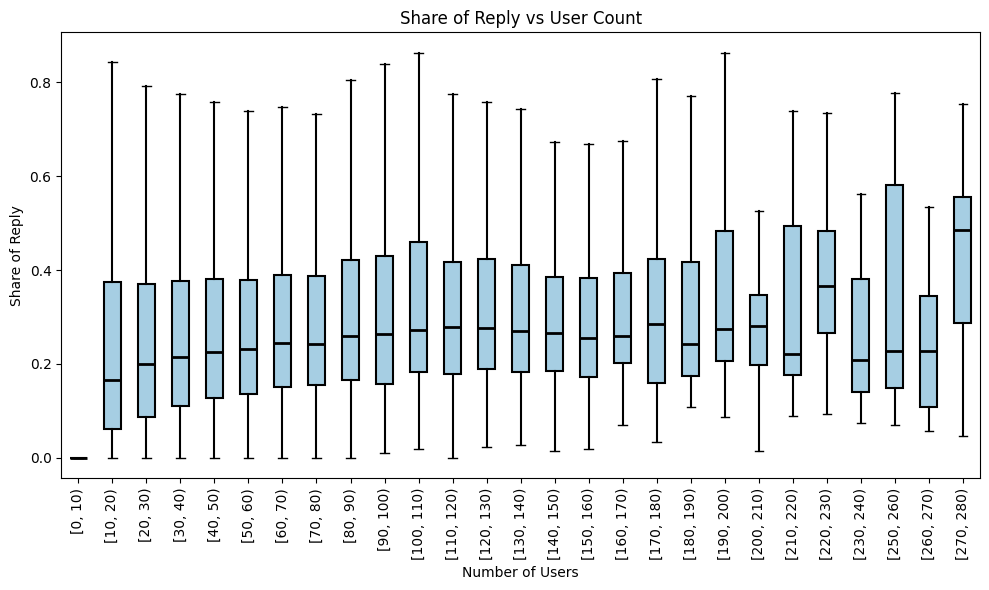

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming 'data' is your DataFrame, for example:
# data = pd.read_csv('your_file.csv')

# Aggiungere la colonna 'alpha' che indica se è il primo commento dell'utente per ogni post_id
data['alpha'] = data.groupby(['post_id', 'user_id']).cumcount() != 0

# Calcolare il numero di utenti unici per ogni post_id
user_count = data.groupby('post_id')['user_id'].nunique()

# Calcolare il numero di commenti per ogni post_id
comment_count = data.groupby('post_id').size()

# Calcolare il rapporto tra il numero di utenti unici e il numero di commenti
user_per_comment_ratio = comment_count / user_count

# Calcolare la media di alpha per ogni post_id (quanti primi commenti ci sono in media per post)
alpha_avg = data.groupby('post_id')['alpha'].mean()

# Creare un DataFrame con tutti i valori richiesti
result = pd.DataFrame({
    'user_count': user_count,
    'comment_count': comment_count,
    'user_per_comment_ratio': user_per_comment_ratio,
    'share_of_reply': alpha_avg
})

# Binning the 'user_count' from 0 to 1000 with step 10
bins = np.arange(0, 1010, 10)
result['user_count_bin'] = pd.cut(result['user_count'], bins=bins, right=False)

# Filter the bins where there are more than 10 observations
valid_bins = result['user_count_bin'].value_counts()[result['user_count_bin'].value_counts() > 10].index
filtered_result = result[result['user_count_bin'].isin(valid_bins)]

# Sort the bins to ensure the x-axis order
sorted_bins = sorted(valid_bins, key=lambda x: x.left)

# Define a color palette for the boxplot (customize based on your preferred color scheme)
palette = plt.cm.Paired  # Example palette, can be replaced with another
colors = [palette(i / len(sorted_bins)) for i in range(len(sorted_bins))]

# Plotting boxplots for 'user_per_comment_ratio' or 'alpha_avg' based on the bins
plt.figure(figsize=(10, 6))

# Plot the boxplot for 'share_of_reply'
plt.boxplot(
    [filtered_result[filtered_result['user_count_bin'] == bin_]['share_of_reply'] for bin_ in sorted_bins],
    labels=[str(bin_) for bin_ in sorted_bins],
    patch_artist=True,  # Fill boxes with color
    showfliers=False,   # Remove outliers
    boxprops=dict(facecolor=colors[0], linewidth=1.5),  # Custom color for boxes
    whiskerprops=dict(linewidth=1.5),  # Customize whiskers
    medianprops=dict(color='black', linewidth=2)  # Median line customization
)

# Adding labels and title
plt.title(str(platform.capitalize()))
plt.xlabel('Number of Users')
plt.ylabel('Share of Reply')

# Remove gridlines for a cleaner look
plt.grid(False)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90, fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()
